In [1]:
# Checking if a GPU is available for training a model
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 251649710364519176
 xla_global_id: -1]

In [2]:
import psutil
# Display detailed information about the system's memory
# Get detailed memory information
mem_info = psutil.virtual_memory()

# Display the memory info
print(f"Total Memory: {mem_info.total / (1024 ** 3):.2f} GB")
print(f"Available Memory: {mem_info.available / (1024 ** 3):.2f} GB")
print(f"Used Memory: {mem_info.used / (1024 ** 3):.2f} GB")
print(f"Memory Usage Percentage: {mem_info.percent}%")

Total Memory: 31.16 GB
Available Memory: 14.94 GB
Used Memory: 16.21 GB
Memory Usage Percentage: 52.0%


In [3]:
# Get CPU information
cpu_info = psutil.cpu_freq()

# Display the CPU info
print(f"CPU Frequency: {cpu_info.current:.2f} MHz")
print(f"CPU Cores: {psutil.cpu_count(logical=False)}")
print(f"Logical CPUs: {psutil.cpu_count(logical=True)}")

CPU Frequency: 4501.00 MHz
CPU Cores: 8
Logical CPUs: 16


In [4]:
import os
import json

# Get the user's home directory (works for both Windows and Linux)
kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")

# Create the .kaggle directory if it doesn't exist
os.makedirs(kaggle_dir, exist_ok=True)

# Write your Kaggle API credentials to the kaggle.json file
kaggle_credentials = {
    "username": "jakehorton",  # Replace with your actual username
    "key": "78823b2ad4c8ced42a61d2b0494b3bcc"  # Replace with your actual API key
}
with open(os.path.join(kaggle_dir, "kaggle.json"), "w+") as f:
    json.dump(kaggle_credentials, f)

# Set file permissions (optional for Windows)
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

print(f"Credentials saved to: {os.path.join(kaggle_dir, 'kaggle.json')}")


Credentials saved to: C:\Users\jakeh\.kaggle\kaggle.json


In [5]:
# Download the dataset using Kaggle API
!kaggle datasets download behrad3d/nasa-cmaps

# Create the train directory
os.makedirs("train", exist_ok=True)

# Unzip the downloaded file using Python
import zipfile

with zipfile.ZipFile("nasa-cmaps.zip", 'r') as zip_ref:
    zip_ref.extractall("train")

print("Unzipping complete!")


nasa-cmaps.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipping complete!


In [6]:
PM_train = 'C:/Users/jakeh/OneDrive/Documents/NLX and LLM/train/CMaps/train_FD001.txt'
PM_test = 'C:/Users/jakeh/OneDrive/Documents/NLX and LLM/train/CMaps/test_FD001.txt'
PM_truth = 'C:/Users/jakeh/OneDrive/Documents/NLX and LLM/train/CMaps/RUL_FD001.txt'

# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from torchinfo import summary
import keras

# define path to save model
model_path = 'binary_model.keras'

## Data Ingestion

In [10]:
# Read training data - Aircraft engine run-to-failure data
train_df = pd.read_csv(PM_train, sep='\s+', header=None) # Read the txt file, use appropriate separator and header
train_df.columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 
           'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df = train_df.sort_values(['unit_number', 'time_in_cycles'])  # Sort by id and cycle

# Read test data - Aircraft engine operating data without failure events recorded
test_df = pd.read_csv(PM_test, sep='\s+',header=None) # Read the txt file, use appropriate separator and header
test_df.columns =  ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 
           'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]  # Assign names to all the columns
test_df = test_df.sort_values(['unit_number', 'time_in_cycles'])  # Sort by id and cycle

# Read ground truth data - True remaining cycles for each engine in testing data
truth_df = pd.read_csv(PM_truth, sep='\s+', header=None) # Read the txt file, use appropriate separator and header

Low variance columns: Index(['operational_setting_1', 'operational_setting_2',
       'operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5',
       'sensor_measurement_6', 'sensor_measurement_10',
       'sensor_measurement_16', 'sensor_measurement_18',
       'sensor_measurement_19'],
      dtype='object')


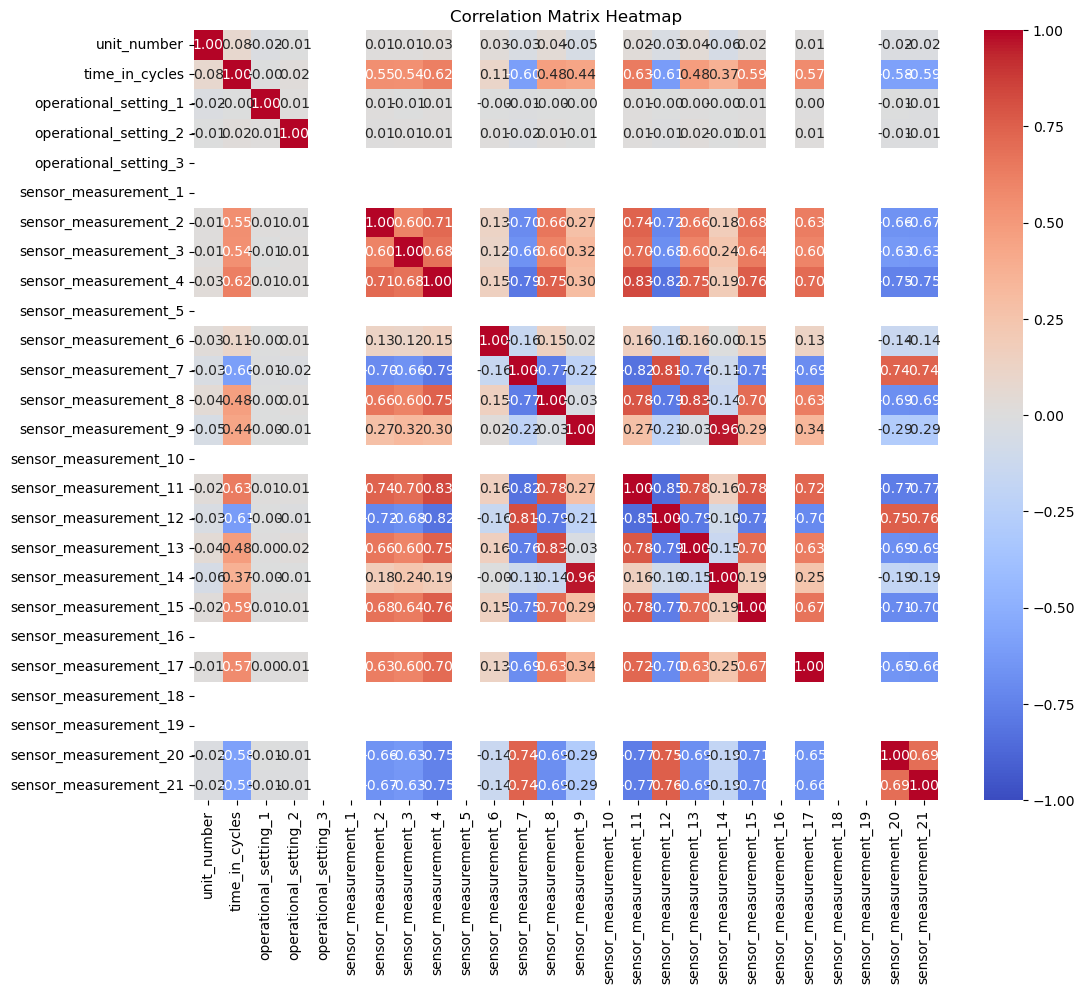

Highly correlated columns:
                       unit_number  time_in_cycles  operational_setting_1  \
unit_number                    1.0             NaN                    NaN   
time_in_cycles                 NaN             1.0                    NaN   
operational_setting_1          NaN             NaN                    1.0   
operational_setting_2          NaN             NaN                    NaN   
operational_setting_3          NaN             NaN                    NaN   
sensor_measurement_1           NaN             NaN                    NaN   
sensor_measurement_2           NaN             NaN                    NaN   
sensor_measurement_3           NaN             NaN                    NaN   
sensor_measurement_4           NaN             NaN                    NaN   
sensor_measurement_5           NaN             NaN                    NaN   
sensor_measurement_6           NaN             NaN                    NaN   
sensor_measurement_7           NaN             Na

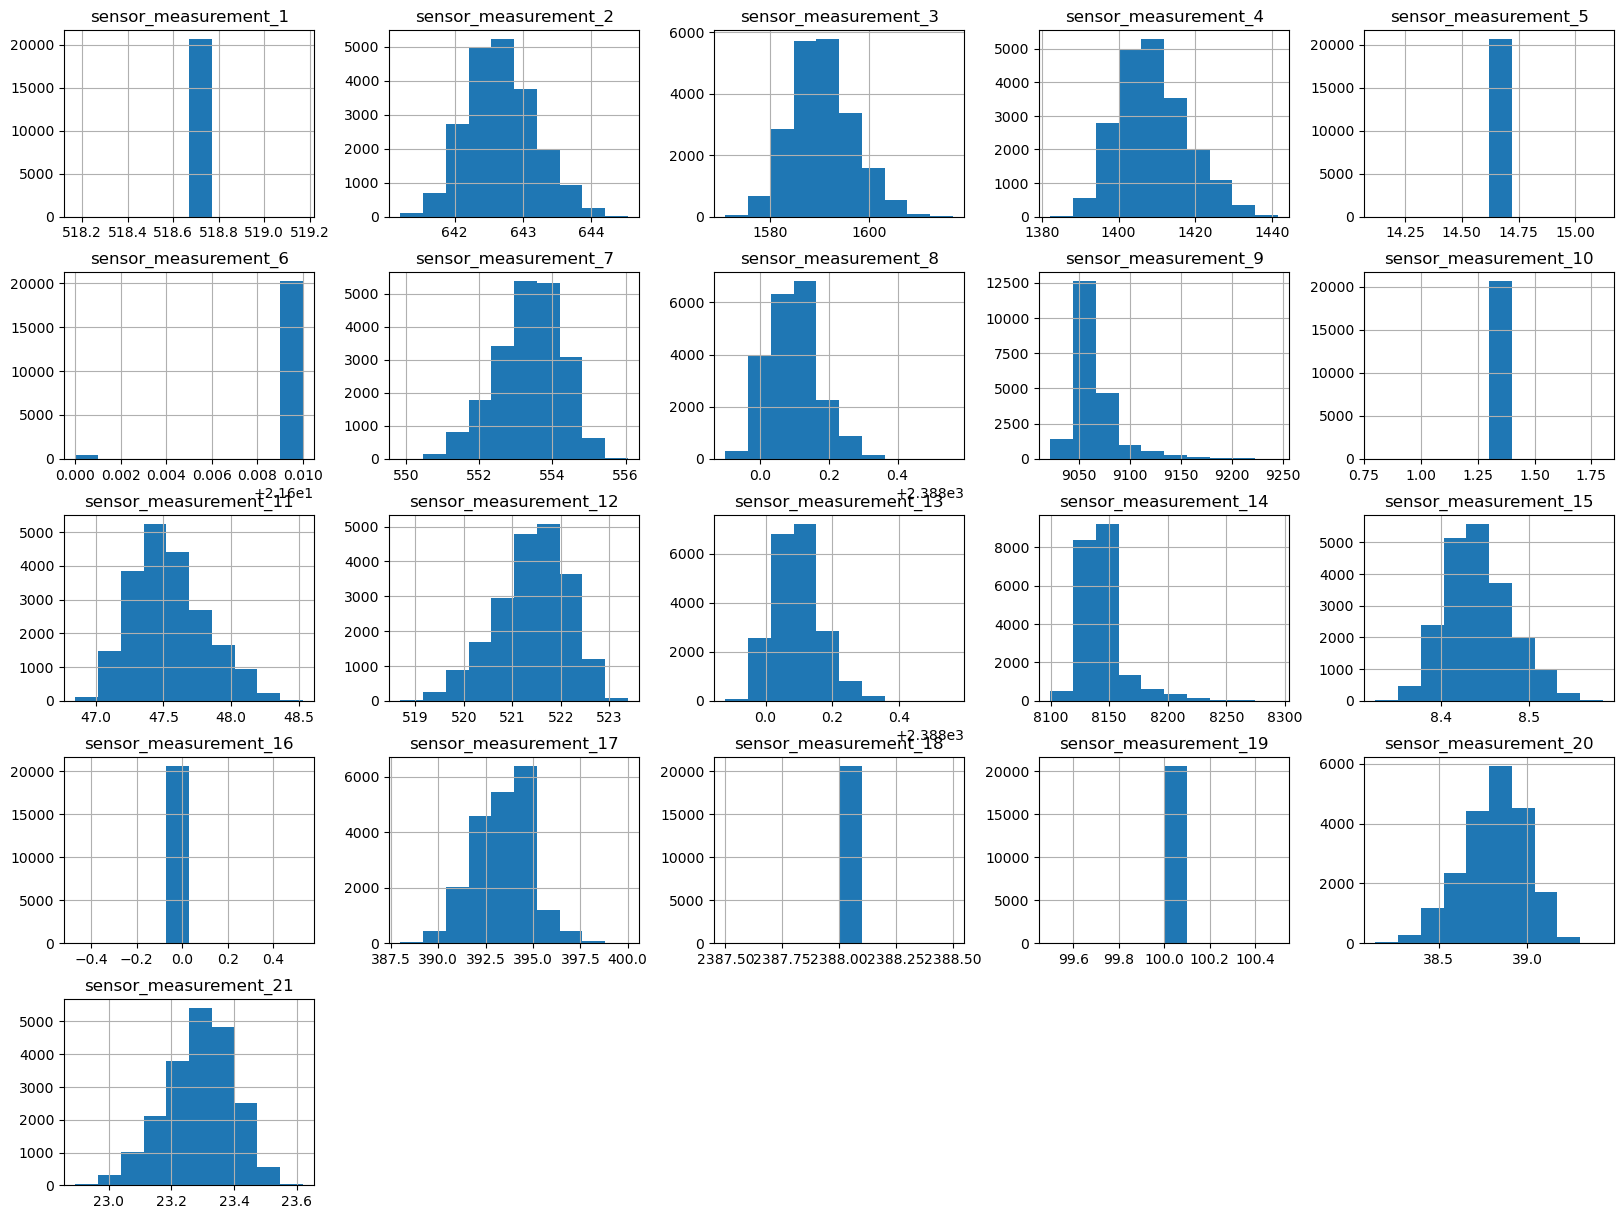

In [11]:
# Data Exploration for training data
# Check for constant columns or columns with very low variance
low_variance_cols = train_df.columns[train_df.var() < 1e-5] 
print(f"Low variance columns: {low_variance_cols}")

# Compute the correlation matrix
correlation_matrix = train_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Identify columns with high correlation (e.g., above 0.95)
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.95]
print("Highly correlated columns:")
print(high_corr_pairs)

# Check for missing values
missing_data = train_df.isnull().sum()
print("Missing values per column:")
print(missing_data)

# Plot histograms for sensor measurements
sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df[sensor_columns].hist(figsize=(20, 15))
plt.show()

Low variance columns: Index(['operational_setting_1', 'operational_setting_2',
       'operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5',
       'sensor_measurement_6', 'sensor_measurement_10',
       'sensor_measurement_16', 'sensor_measurement_18',
       'sensor_measurement_19'],
      dtype='object')


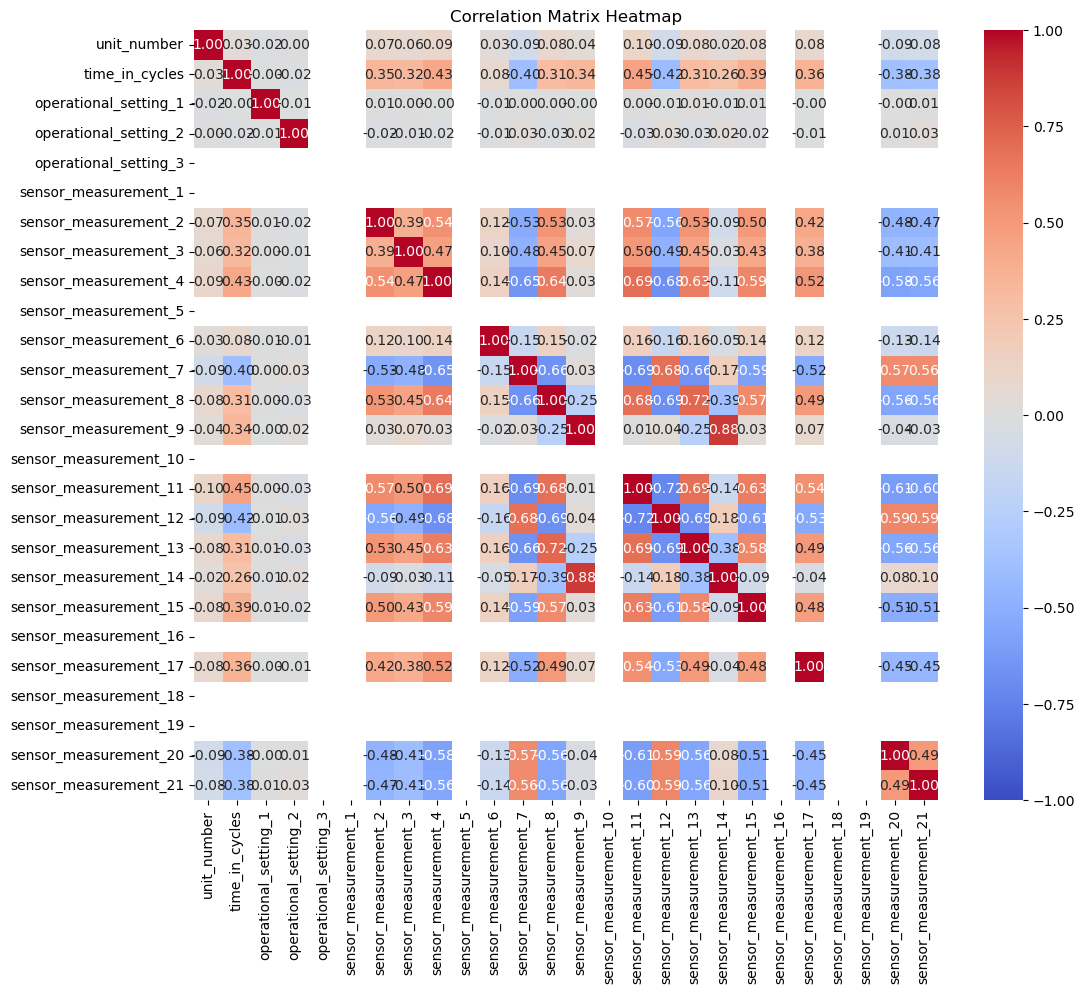

Highly correlated columns:
                       unit_number  time_in_cycles  operational_setting_1  \
unit_number                    1.0             NaN                    NaN   
time_in_cycles                 NaN             1.0                    NaN   
operational_setting_1          NaN             NaN                    1.0   
operational_setting_2          NaN             NaN                    NaN   
operational_setting_3          NaN             NaN                    NaN   
sensor_measurement_1           NaN             NaN                    NaN   
sensor_measurement_2           NaN             NaN                    NaN   
sensor_measurement_3           NaN             NaN                    NaN   
sensor_measurement_4           NaN             NaN                    NaN   
sensor_measurement_5           NaN             NaN                    NaN   
sensor_measurement_6           NaN             NaN                    NaN   
sensor_measurement_7           NaN             Na

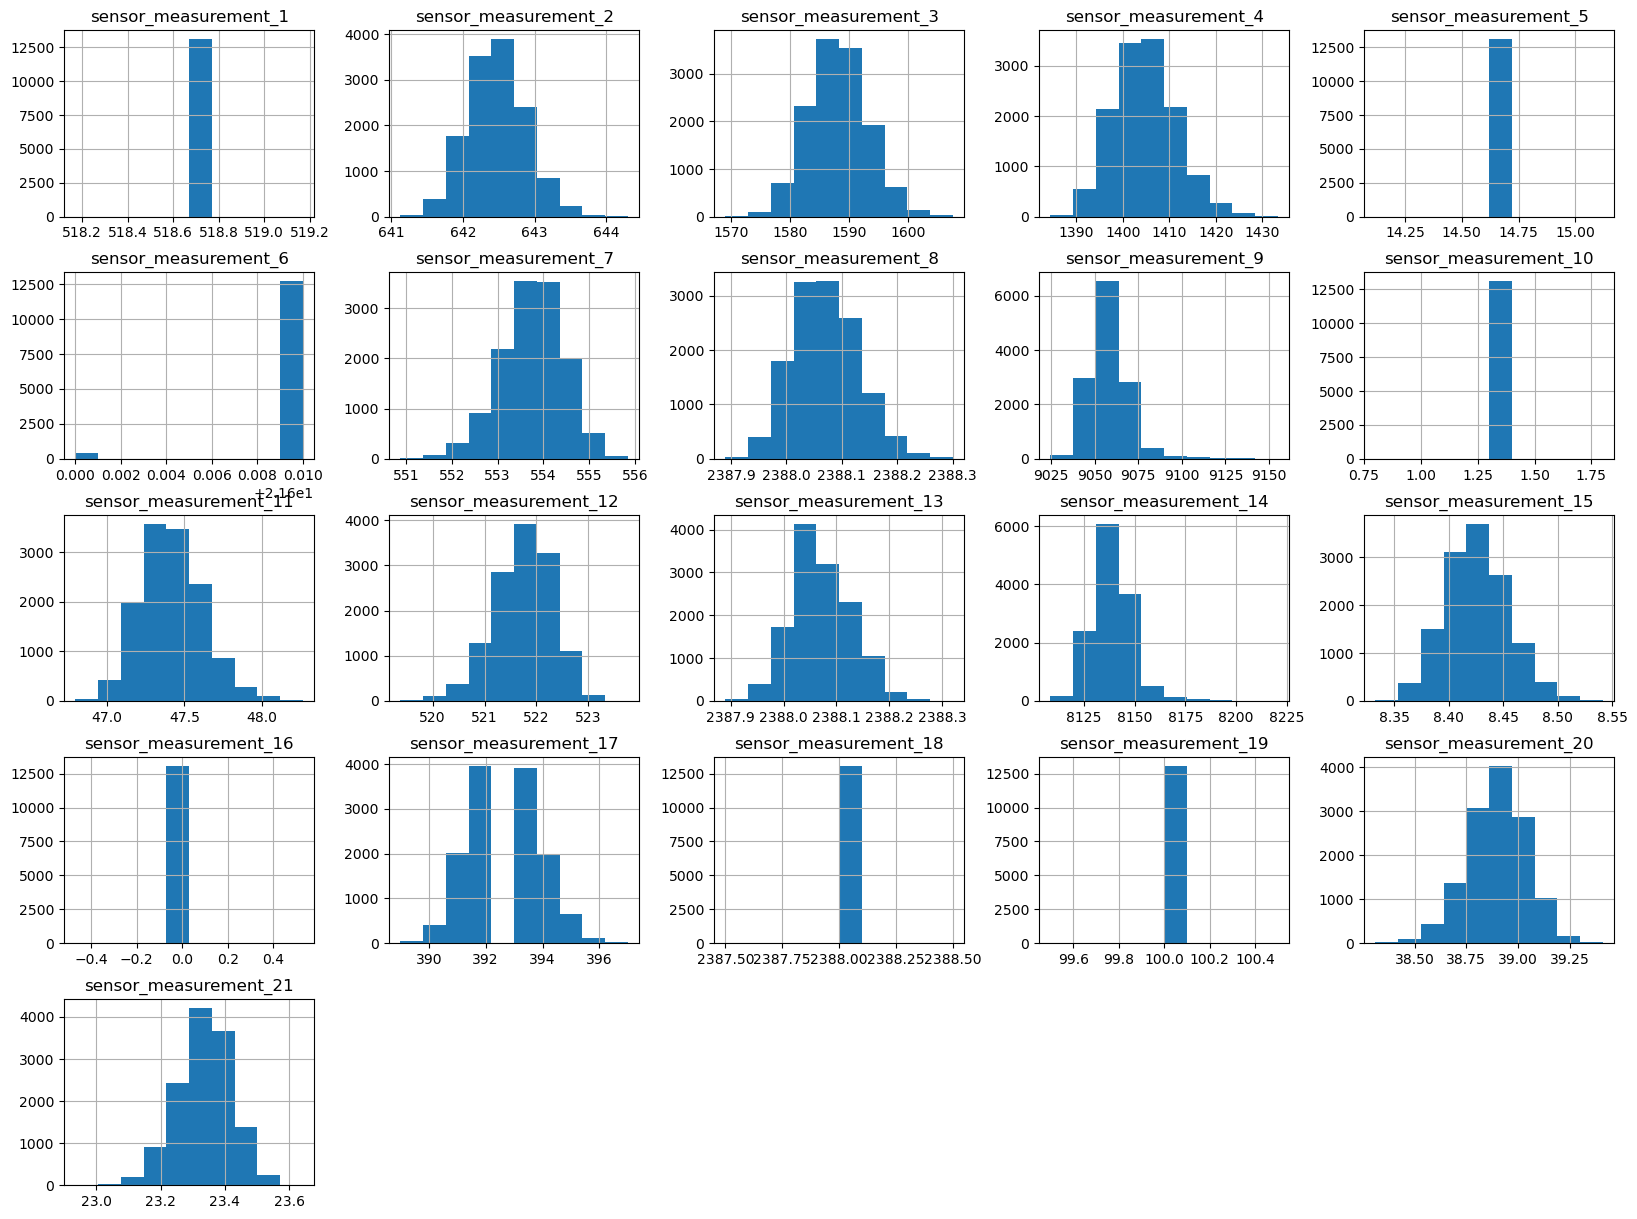

In [12]:
# Data Exploration for test data
# Check for constant columns or columns with very low variance
low_variance_cols = test_df.columns[train_df.var() < 1e-5] 
print(f"Low variance columns: {low_variance_cols}")

# Compute the correlation matrix
correlation_matrix = test_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Identify columns with high correlation (e.g., above 0.95)
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.95]
print("Highly correlated columns:")
print(high_corr_pairs)

# Check for missing values
missing_data = test_df.isnull().sum()
print("Missing values per column:")
print(missing_data)

# Plot histograms for sensor measurements
sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 22)]
test_df[sensor_columns].hist(figsize=(20, 15))
plt.show()

In [13]:
train_df.drop(['sensor_measurement_1','sensor_measurement_4','sensor_measurement_5','sensor_measurement_14','sensor_measurement_16',
              'sensor_measurement_18','sensor_measurement_19'], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
test_df.drop(['sensor_measurement_1','sensor_measurement_4','sensor_measurement_5','sensor_measurement_14','sensor_measurement_16',
              'sensor_measurement_18','sensor_measurement_19'], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns

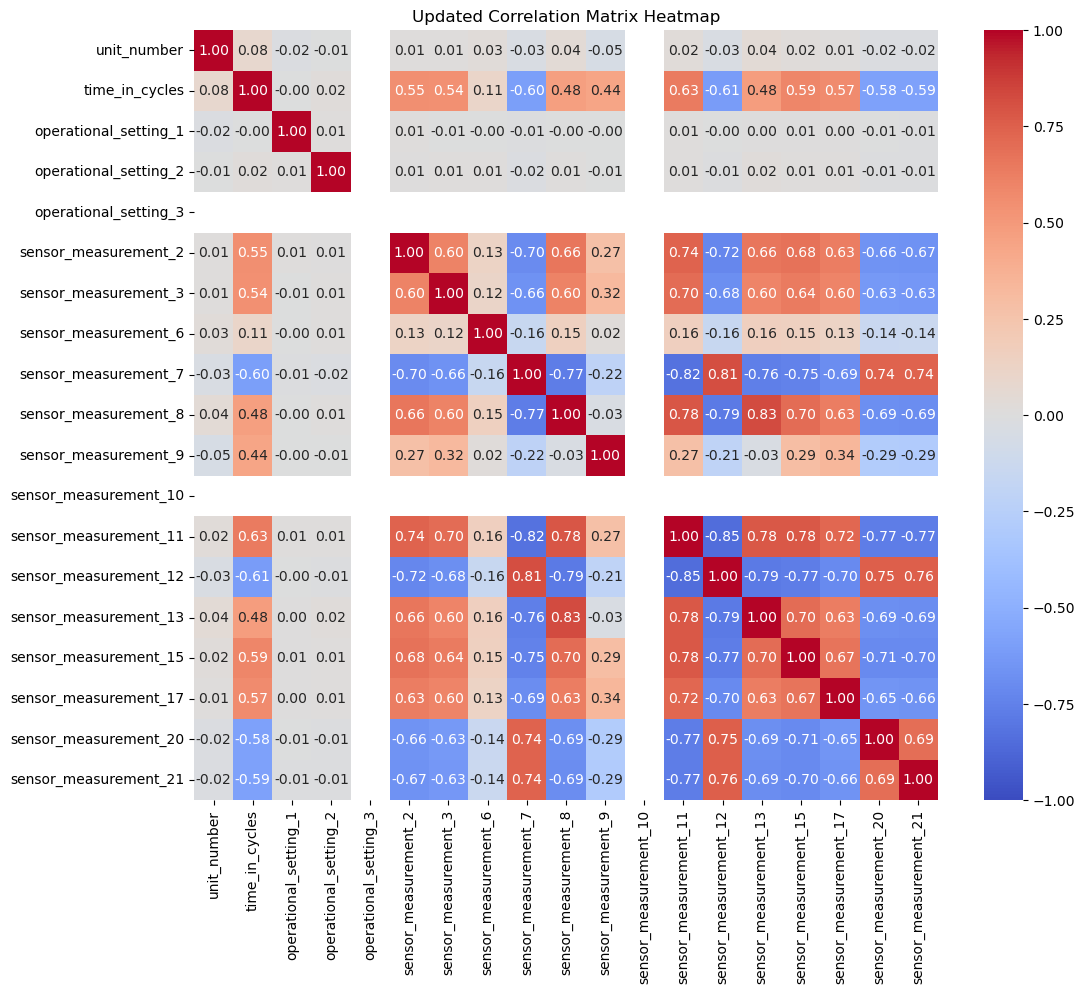

In [14]:
# Recompute the correlation matrix after dropping columns
correlation_matrix = train_df.corr()

# Plot a heatmap of the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Updated Correlation Matrix Heatmap')
plt.show()

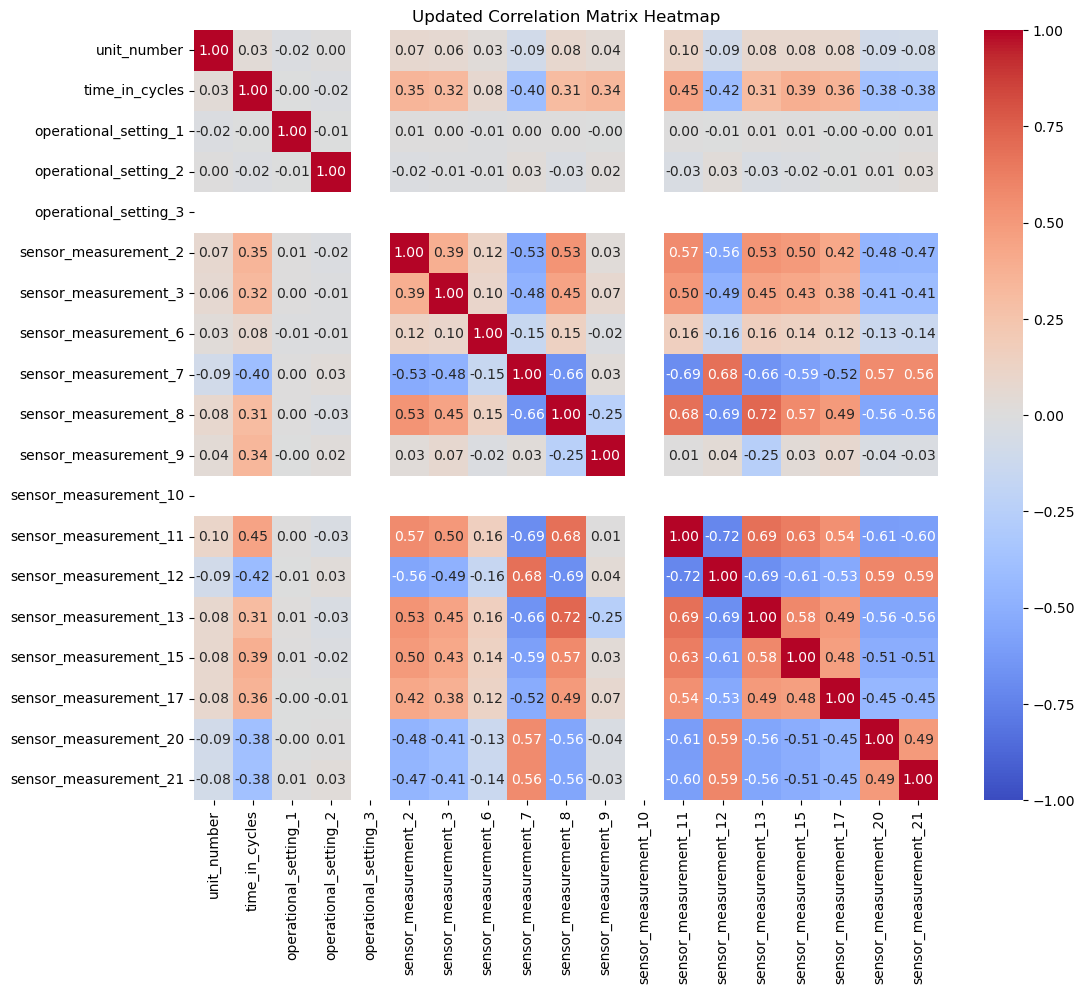

In [15]:
# Recompute the correlation matrix after dropping columns
correlation_matrix = test_df.corr()

# Plot a heatmap of the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Updated Correlation Matrix Heatmap')
plt.show()

## Data Preprocessing

In [17]:
#######
# TRAIN
#######

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)

# Calculate the maximum cycle value for each engine (id) and store it in a new DataFrame (rul)
rul = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()

# Rename the columns in the rul DataFrame
rul.columns = ['unit_number', 'max_cycle']

# Merge the rul DataFrame with the original train_df based on the 'id' column
train_df = train_df.merge(rul, on='unit_number')

# Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']

# Remove the temporary column used to calculate RUL
train_df.drop('max_cycle', axis=1, inplace=True)

# Generate label columns for training data
w1 = 30
w0 = 15

# Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)

# Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1']

# Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
# Create a normalized version of the 'cycle' column (e.g., 'cycle_norm') using the original 'cycle' values
train_df['cycle_norm'] = train_df['time_in_cycles'] / train_df.groupby('unit_number')['time_in_cycles'].transform('max')

# Select the columns to be normalized (all columns except 'unit_number', 'time_in_cycles', 'RUL', 'label1', and 'label2')
cols_normalize = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL', 'label1', 'label2', 'cycle_norm']]

# Initialize a MinMaxScaler object to scale values between 0 and 1
min_max_scaler = MinMaxScaler()

# Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

# Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
train_df_dropped = train_df.drop(cols_normalize, axis=1)
train_df = train_df_dropped.join(norm_train_df)

# Reorder the columns in the joined DataFrame to match the original order
train_df = train_df[['unit_number', 'time_in_cycles', 'cycle_norm', 'RUL', 'label1', 'label2'] + cols_normalize]

#######
# TEST
#######

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['time_in_cycles'] / test_df.groupby('unit_number')['time_in_cycles'].transform('max')

# Apply MinMaxScaler to the selected columns in the test data (use the same columns as in train_df)
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)

# Join the normalized DataFrame with the original test DataFrame
test_join_df = test_df.drop(cols_normalize, axis=1)
test_df = test_join_df.join(norm_test_df)

# Calculate the maximum cycle value for each engine in the test data
rul = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()

# Rename the columns in the rul DataFrame
rul.columns = ['unit_number', 'max_cycle']

# Merge the rul DataFrame with the original test_df
test_df = test_df.merge(rul, on='unit_number')

# Calculate the Remaining Useful Life (RUL)
test_df['RUL'] = test_df['max_cycle'] - test_df['time_in_cycles']
test_df.drop('max_cycle', axis=1, inplace=True)

# Merge the rul DataFrame with the original test_df based on the 'unit_number' column
# Ensure 'truth_df' has the correct number of columns
truth_df['unit_number'] = truth_df.index + 1  # Create 'unit_number' column

# Rename the existing column to 'more'
truth_df.rename(columns={truth_df.columns[0]: 'more'}, inplace=True)

# Generate the maximum cycle value for test data
truth_df['max_cycle'] = rul['max_cycle'] + truth_df['more']

# Remove the temporary column used to calculate RUL
truth_df.drop('more', axis=1, inplace=True)

# Merge the adjusted truth_df with the test_df to generate RUL values for test data
test_df = test_df.merge(truth_df[['unit_number', 'max_cycle']], on='unit_number', how='left')

# Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
test_df['RUL'] = test_df['max_cycle'] - test_df['time_in_cycles']
test_df.drop('max_cycle', axis=1, inplace=True)

# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
w1 = 30
w0 = 15
test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

from sklearn.utils.class_weight import compute_class_weight

# Convert classes to NumPy arrays
classes_label1 = np.array([0, 1])
classes_label2 = np.array([0, 1, 2])

# Compute class weights for label1
class_weights_label1 = compute_class_weight('balanced', classes=classes_label1, y=train_df['label1'])

# Convert to dictionary format for Keras
class_weight_dict_label1 = {0: class_weights_label1[0], 1: class_weights_label1[1]}
print(class_weight_dict_label1)

# Compute class weights for label2
class_weights_label2 = compute_class_weight('balanced', classes=classes_label2, y=train_df['label2'])

# Convert to dictionary format for Keras
class_weight_dict_label2 = {0: class_weights_label2[0], 1: class_weights_label2[1], 2: class_weights_label2[2]}
print(class_weight_dict_label2)                   

{0: 0.5884148080543038, 1: 3.3275806451612904}
{0: 0.3922765387028692, 1: 4.584666666666666, 2: 4.298125}


In [18]:
print(train_df['label1'].value_counts())
print(train_df['label2'].value_counts())

label1
0    17531
1     3100
Name: count, dtype: int64
label2
0    17531
2     1600
1     1500
Name: count, dtype: int64


## LSTM

In [20]:
# Define sequence length
sequence_length = 50

# Define feature columns for sequence generation
sequence_columns = ['time_in_cycles', 'cycle_norm', 'operational_setting_1',
                    'operational_setting_2', 'operational_setting_3',
                    'sensor_measurement_2', 'sensor_measurement_3',
                    'sensor_measurement_6', 'sensor_measurement_7',
                    'sensor_measurement_8', 'sensor_measurement_9',
                    'sensor_measurement_10', 'sensor_measurement_11',
                    'sensor_measurement_12', 'sensor_measurement_13',
                    'sensor_measurement_15', 'sensor_measurement_17',
                    'sensor_measurement_20', 'sensor_measurement_21']

# Function to reshape features into (samples, time steps, features)
def generate_sequences(id_df, sequence_length, feature_columns):
    data_matrix = id_df[feature_columns].values  # Extract data as numpy array
    num_elements = data_matrix.shape[0]
    
    # Generate sequences of length sequence_length
    for start, end in zip(range(0, num_elements - sequence_length), range(sequence_length, num_elements)):
        yield data_matrix[start:end]

# Generate sequences for all engine ids in the training data
sequence_generator = (generate_sequences(train_df[train_df['unit_number'] == unit_id], sequence_length, sequence_columns) 
                      for unit_id in train_df['unit_number'].unique())

# Convert generated sequences to a numpy array for LSTM input
sequence_array = np.array([seq for engine_seq in sequence_generator for seq in engine_seq])

# Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    data_matrix = id_df[label_column].values  # Extract labels as numpy array
    num_elements = data_matrix.shape[0]
    
    # Generate the labels corresponding to the sequences
    return data_matrix[sequence_length:num_elements]

# Generate labels for all engine ids in the training data
label_generator = [generate_labels(train_df[train_df['unit_number'] == unit_id], sequence_length, 'label1') 
                   for unit_id in train_df['unit_number'].unique()]

# Convert generated labels to a numpy array
label_array = np.concatenate(label_generator).ravel()

In [21]:
# Define the number of features (input shape) and output units
nb_out = 1  # For binary classification, the output should be a single unit
nb_features = sequence_array.shape[2]  # Number of features from the sequence array

# Create a Sequential model
model = Sequential()

# Add LSTM layer
# Adjust the number of units to keep total parameters under 10,000
model.add(LSTM(units=32, input_shape=(sequence_length, nb_features), return_sequences=False))

# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the output layer (Dense layer with sigmoid activation for binary classification)
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

C:\Users\jakeh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,689 (26.13 KB)

 Trainable params: 6,689 (26.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Fit the network to the training data
history = model.fit(
    sequence_array,
    label_array,
    epochs=50,  # Example: 50 training epochs
    batch_size=32,  # Example: batch size of 32
    validation_split=0.2,  # Example: 20% of the data used for validation
    verbose=1,  # Example: Show a progress bar for each epoch
    callbacks=[
        # Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Minimum change in validation loss to qualify as improvement
            patience=10,  # Wait for 10 epochs with no improvement
            verbose=1,  # Show messages when early stopping is triggered
            mode='min'
        ),
        # Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # File path to save the best model, using `.keras` extension
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1  # Show messages when the model is saved
        )
    ]
)


Epoch 1/50
381/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7033 - loss: 0.4879
Epoch 1: val_loss improved from inf to 0.38001, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7054 - loss: 0.4851 - val_accuracy: 0.8481 - val_loss: 0.3800
Epoch 2/50
381/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8314 - loss: 0.3279
Epoch 2: val_loss improved from 0.38001 to 0.31996, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8315 - loss: 0.3277 - val_accuracy: 0.8519 - val_loss: 0.3200
Epoch 3/50
382/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8781 - loss: 0.2704
Epoch 3: val_loss improved from 0.31996 to 0.23350, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8785 - loss: 0.2698 - val_accuracy: 0.8871 - val_loss: 0.2335
Epoch 4/50
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0.1973
Epoch 4: val_loss improved from 0.23350 to 0.15990, sa

## Model Evaluation on Test set

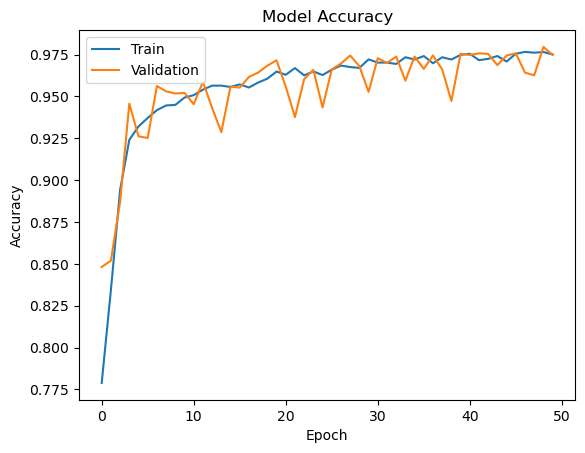

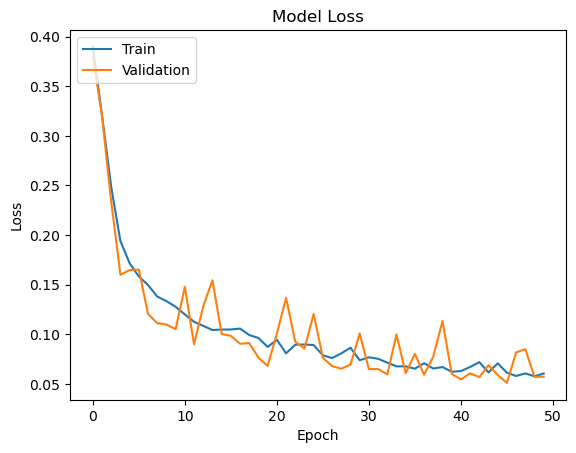

489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9814 - loss: 0.0426
Training Accuracy: 97.84%
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12243   288]
 [   49  3051]]
Precision: 0.95
Recall: 0.98


In [24]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

# Evaluate the model on the training data
scores = model.evaluate(sequence_array, label_array, verbose=1)
print(f'Training Accuracy: {scores[1] * 100:.2f}%')

# Make predictions on the training data
y_pred_prob = model.predict(sequence_array)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Save predictions to a CSV file
test_set = pd.DataFrame(y_pred, columns=['Predicted_Label'])
test_set.to_csv('predicted_labels.csv', index=False)

# Compute confusion matrix
cm = confusion_matrix(label_array, y_pred)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# Calculate precision and recall using 'macro' averaging for multiclass classification
precision = precision_score(label_array, y_pred, average='macro', zero_division=0)
recall = recall_score(label_array, y_pred, average='macro', zero_division=0)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

## Model Evaluation on Validation set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.0686  
Accuracy: 95.70%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[64  4]
 [ 0 25]]
Precision: 0.93
Recall: 0.97
F1-score: 0.95


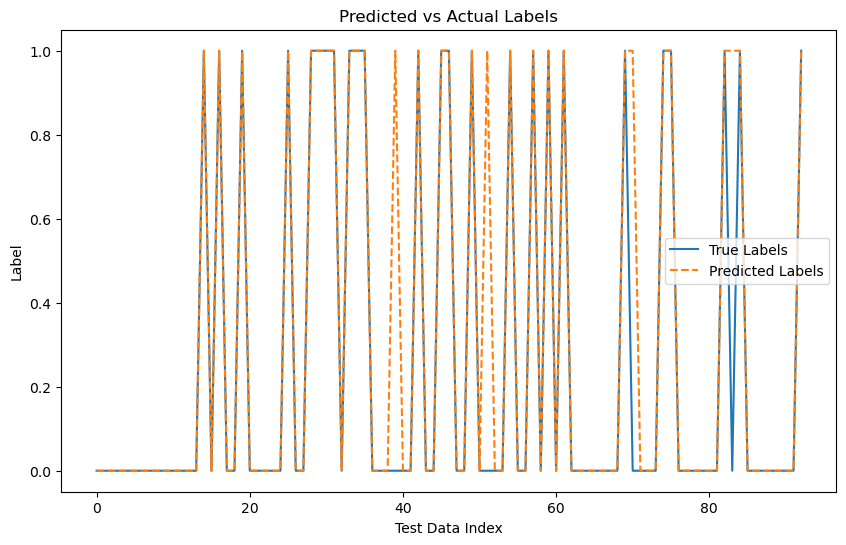

In [26]:
# Define sequence length and sequence columns (same as in training)
sequence_length = 50

# Correct sequence columns based on your dataset
sequence_columns = ['time_in_cycles', 'cycle_norm', 'operational_setting_1',
                    'operational_setting_2', 'operational_setting_3',
                    'sensor_measurement_2', 'sensor_measurement_3',
                    'sensor_measurement_6', 'sensor_measurement_7',
                    'sensor_measurement_8', 'sensor_measurement_9',
                    'sensor_measurement_10', 'sensor_measurement_11',
                    'sensor_measurement_12', 'sensor_measurement_13',
                    'sensor_measurement_15', 'sensor_measurement_17',
                    'sensor_measurement_20', 'sensor_measurement_21']

# Pick the last sequence for each engine in the test data
seq_array_test_last = []
for unit_id in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit_id]
    if len(unit_data) >= sequence_length:  # Ensure sequence is long enough
        seq_array_test_last.append(unit_data[sequence_columns].values[-sequence_length:])

# Convert to numpy array and ensure float32 data type
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Pick the labels for the selected sequences
y_mask = test_df.groupby('unit_number')['time_in_cycles'].max() >= sequence_length
label_array_test_last = test_df.groupby('unit_number')['label1'].last()[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

# Load the saved model if it exists
model_path = 'best_model.keras'  # Replace with your actual model path
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=1)
print('Accuracy: {:.2f}%'.format(scores_test[1] * 100))

# Make predictions on the test data
y_pred_test_prob = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob >= 0.5).astype(int)

# True labels for the test data
y_true_test = label_array_test_last

# Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame(y_pred_test, columns=['Predicted_Label'])
test_set.to_csv('predicted_test_labels.csv', index=False)

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test, average='macro', zero_division=0)
recall_test = recall_score(y_true_test, y_pred_test, average='macro', zero_division=0)
f1_test = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

print('Precision: {:.2f}'.format(precision_test))
print('Recall: {:.2f}'.format(recall_test))
print('F1-score: {:.2f}'.format(f1_test))

# Plot predicted vs actual labels
plt.figure(figsize=(10, 6))
plt.plot(y_true_test, label='True Labels')
plt.plot(y_pred_test, label='Predicted Labels', linestyle='--')
plt.title('Predicted vs Actual Labels')
plt.xlabel('Test Data Index')
plt.ylabel('Label')
plt.legend()
plt.savefig('predicted_vs_actual.png')
plt.show()

In [27]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.956989,0.931034,0.970588,0.947811
Template Best Model,0.940000,0.952381,0.800000,0.869565


# GRU

In [29]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight 
from keras.regularizers import l2

# Define sequence length (same as before)
sequence_length = 50

# Define the columns to use for sequences (same as before)
# Define feature columns for sequence generation
sequence_columns = ['time_in_cycles', 'cycle_norm', 'operational_setting_1',
                    'operational_setting_2', 'operational_setting_3',
                    'sensor_measurement_2', 'sensor_measurement_3',
                    'sensor_measurement_6', 'sensor_measurement_7',
                    'sensor_measurement_8', 'sensor_measurement_9',
                    'sensor_measurement_10', 'sensor_measurement_11',
                    'sensor_measurement_12', 'sensor_measurement_13',
                    'sensor_measurement_15', 'sensor_measurement_17',
                    'sensor_measurement_20', 'sensor_measurement_21']

# Create sequences for training data
seq_array_train = []
label_array_train = []

for unit_id in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit_id]
    if len(unit_data) >= sequence_length:
        for start, end in zip(range(0, len(unit_data) - sequence_length), range(sequence_length, len(unit_data))):
            seq_array_train.append(unit_data[sequence_columns].values[start:end])
            label_array_train.append(unit_data['label1'].values[end])  # Use 'label1' for binary classification

# Convert to numpy arrays
seq_array_train = np.array(seq_array_train)
label_array_train = np.array(label_array_train)

# Preprocessing test data - last sequence for each unit
seq_array_test_last = []
label_array_test_last = []

for unit_id in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit_id]
    if len(unit_data) >= sequence_length:
        seq_array_test_last.append(unit_data[sequence_columns].values[-sequence_length:])
        label_array_test_last.append(unit_data['label1'].values[-1])

# Convert to numpy arrays
seq_array_test_last = np.array(seq_array_test_last)
label_array_test_last = np.array(label_array_test_last)

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.01)))  # L2 regularization
    model.add(Dropout(0.3))  # Adjust dropout
    model.add(GRU(units=64, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape (sequence_length, number of features)
input_shape = (sequence_length, len(sequence_columns))

# Build and compile the GRU model
model = build_gru_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the GRU model
history = model.fit(
    seq_array_train,  # Training data sequences
    label_array_train,  # Training data labels
    epochs=50,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust the batch size as needed
    validation_split=0.2,  # Split 20% of training data for validation
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8156 - loss: 1.0823
Epoch 1: val_loss improved from inf to 0.43158, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8156 - loss: 1.0813 - val_accuracy: 0.8126 - val_loss: 0.4316
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8593 - loss: 0.3553
Epoch 2: val_loss improved from 0.43158 to 0.23642, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8594 - loss: 0.3552 - val_accuracy: 0.9239 - val_loss: 0.2364
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9227 - loss: 0.2274
Epoch 3: val_loss improved from 0.23642 to 0.19015, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9227 - loss: 0.2274 - val_accuracy: 0.9396 - val_loss: 0.1901
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9436 - loss: 0.1847
Epoch 4: val_loss improved from 0.19015 to 0.14

# Model Evaluation on Test Set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0547 
Test Set Accuracy: 100.00%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/stepWARNING:tensorflow:6 out of the last 495 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024203F5BE20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Confusion Matrix on Test Set:
[[68  0]
 [ 0 25]]
Test Set Precision: 1.00
Test Set Recall: 1.00
T

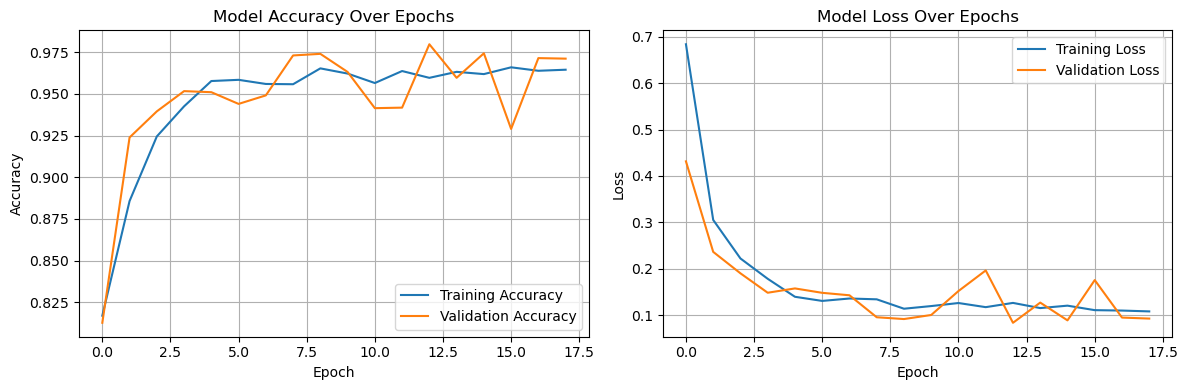

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(seq_array_test_last, label_array_test_last, verbose=1)
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")


# Make predictions on the test set
y_pred_test_prob = model.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob >= 0.5).astype(int)  # Adjust threshold if necessary

# Compute confusion matrix for the test set
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

cm_test = confusion_matrix(label_array_test_last, y_pred_test)
print(f"Confusion Matrix on Test Set:\n{cm_test}")

# Compute precision, recall, and F1-score for the test set
precision_test = precision_score(label_array_test_last, y_pred_test, average='macro', zero_division=0)
recall_test = recall_score(label_array_test_last, y_pred_test, average='macro', zero_division=0)
f1_test = f1_score(label_array_test_last, y_pred_test, average='macro', zero_division=0)

print(f"Test Set Precision: {precision_test:.2f}")
print(f"Test Set Recall: {recall_test:.2f}")
print(f"Test Set F1-Score: {f1_test:.2f}")

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model Evaluation on Validation Set

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8892 - loss: 0.9002 
Validation Set Accuracy: 88.24%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix on Validation Set:
[[120   0]
 [ 16   0]]
Validation Set Precision: 0.44
Validation Set Recall: 0.50
Validation Set F1-Score: 0.47


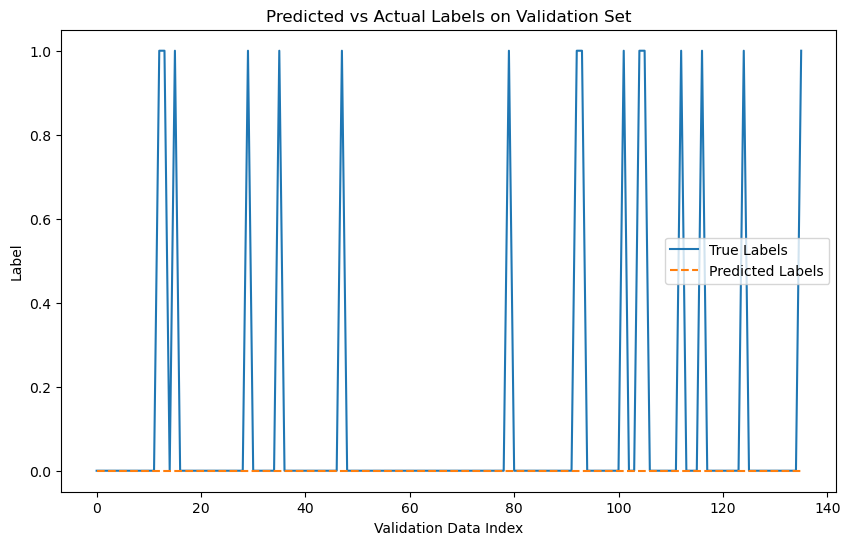

In [33]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets (80% training, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Preprocessing for Validation Data (now you have a val_df)
seq_array_val = []
label_array_val = []

for unit_id in val_df['unit_number'].unique():
    unit_data = val_df[val_df['unit_number'] == unit_id]
    if len(unit_data) >= sequence_length:  # Ensure sequence length is sufficient
        for start, end in zip(range(0, len(unit_data) - sequence_length), range(sequence_length, len(unit_data))):
            seq_array_val.append(unit_data[sequence_columns].values[start:end])
            label_array_val.append(unit_data['label1'].values[end])  # Use 'label1' for binary classification

# Convert to numpy arrays
seq_array_val = np.array(seq_array_val)
label_array_val = np.array(label_array_val)

# Evaluate the model on the validation set
scores_val = model.evaluate(seq_array_val, label_array_val, verbose=1)
print(f"Validation Set Accuracy: {scores_val[1] * 100:.2f}%")

# Make predictions on the validation set
y_pred_val_prob = model.predict(seq_array_val)
y_pred_val = (y_pred_val_prob >= 0.5).astype(int)  # Convert probabilities to class labels

# Compute confusion matrix for the validation set
cm_val = confusion_matrix(label_array_val, y_pred_val)
print(f"Confusion Matrix on Validation Set:\n{cm_val}")

# Compute precision, recall, and F1-score for the validation set
precision_val = precision_score(label_array_val, y_pred_val, average='macro', zero_division=0)
recall_val = recall_score(label_array_val, y_pred_val, average='macro', zero_division=0)
f1_val = f1_score(label_array_val, y_pred_val, average='macro', zero_division=0)

print(f"Validation Set Precision: {precision_val:.2f}")
print(f"Validation Set Recall: {recall_val:.2f}")
print(f"Validation Set F1-Score: {f1_val:.2f}")

# Plot predicted vs actual labels for validation set
plt.figure(figsize=(10, 6))
plt.plot(label_array_val, label='True Labels')
plt.plot(y_pred_val, label='Predicted Labels', linestyle='--')
plt.title('Predicted vs Actual Labels on Validation Set')
plt.xlabel('Validation Data Index')
plt.ylabel('Label')
plt.legend()
plt.show()

# GRU Model with K-Fold Cross Validation 

In [60]:
from sklearn.model_selection import KFold
import numpy as np

# Define sequence length (same as before)
sequence_length = 50

# Define the columns to use for sequences (same as before)
# Define feature columns for sequence generation
sequence_columns = ['time_in_cycles', 'cycle_norm', 'operational_setting_1',
                    'operational_setting_2', 'operational_setting_3',
                    'sensor_measurement_2', 'sensor_measurement_3',
                    'sensor_measurement_6', 'sensor_measurement_7',
                    'sensor_measurement_8', 'sensor_measurement_9',
                    'sensor_measurement_10', 'sensor_measurement_11',
                    'sensor_measurement_12', 'sensor_measurement_13',
                    'sensor_measurement_15', 'sensor_measurement_17',
                    'sensor_measurement_20', 'sensor_measurement_21']

# Create sequences for training data
seq_array_train = []
label_array_train = []

for unit_id in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit_id]
    if len(unit_data) >= sequence_length:
        for start, end in zip(range(0, len(unit_data) - sequence_length), range(sequence_length, len(unit_data))):
            seq_array_train.append(unit_data[sequence_columns].values[start:end])
            label_array_train.append(unit_data['label1'].values[end])  # Use 'label1' for binary classification

# Convert to numpy arrays
seq_array_train = np.array(seq_array_train)
label_array_train = np.array(label_array_train)

# Set up k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Array to store performance metrics for each fold
accuracy_per_fold = []
loss_per_fold = []

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kfold.split(seq_array_train)):
    print(f"Training fold {fold + 1}/{kfold.n_splits}...")
    
    # Split data into training and validation sets for this fold
    x_train_fold = seq_array_train[train_index]
    y_train_fold = label_array_train[train_index]
    x_val_fold = seq_array_train[val_index]
    y_val_fold = label_array_train[val_index]

    # Build the model again for each fold
    model = build_gru_model(input_shape)

    # Define early stopping and model checkpoint for each fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold + 1}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    # Train the model on this fold
    history = model.fit(
        x_train_fold,  # Training data for this fold
        y_train_fold,  # Training labels for this fold
        epochs=50,  # Adjust as needed
        batch_size=32,  # Adjust as needed
        validation_data=(x_val_fold, y_val_fold),  # Validation data for this fold
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set for this fold
    scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold + 1} - Loss: {scores[0]} - Accuracy: {scores[1]}")

    # Store the fold's performance
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

# Report the performance across all folds
print(f"\nAverage Accuracy: {np.mean(accuracy_per_fold)}")
print(f"Average Loss: {np.mean(loss_per_fold)}")

Training fold 1/5...
Epoch 1/50
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8328 - loss: 1.3542
Epoch 1: val_loss improved from inf to 0.53042, saving model to best_model_fold_1.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8329 - loss: 1.3512 - val_accuracy: 0.8496 - val_loss: 0.5304
Epoch 2/50
286/288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8468 - loss: 0.5121
Epoch 2: val_loss improved from 0.53042 to 0.45690, saving model to best_model_fold_1.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8468 - loss: 0.5119 - val_accuracy: 0.8496 - val_loss: 0.4569
Epoch 3/50
286/288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8498 - loss: 0.4568
Epoch 3: val_loss improved from 0.45690 to 0.45402, saving model to best_model_fold_1.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8497 - loss: 0.4568 - val_accuracy: 0.8496 - val_loss: 0.4540
Epoch 4/50
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8490 - loss: 0.4434
Epoch